2024-02-01 15:14:07.995334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 15:14:08.585539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Algorithm pc
./Adult_Analysis/pc/PP/Adult_pc_pp_30.csv


2024-02-01 15:14:11.792023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 15:14:11.792255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 15:14:11.808151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2024-02-01 15:14:12.131530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-02-01 15:14:12.135264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-02-01 15:14:12.156273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'poisson_noncpu/batched_las_vegas_algorithm/while/uniform/stateless_random_uniform/StatelessRa

0.07488802058515201


KeyboardInterrupt: 

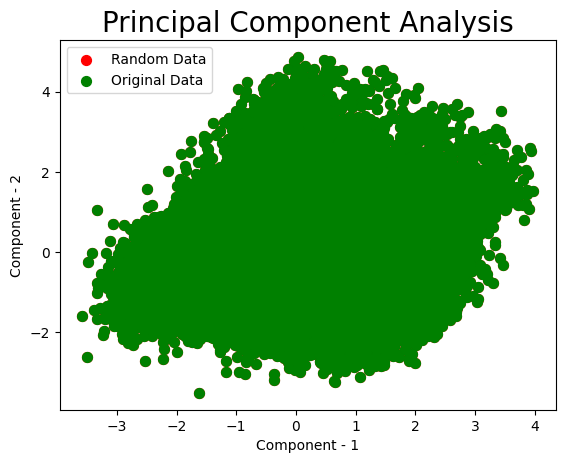

In [2]:
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("./subjects/")
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
import tensorflow as tf
import time
import random, math
import tensorflow_probability as tfb
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import  euclidean_distances
from Utils_Functions import KLdivergence
from sklearn.feature_selection import SelectKBest, SelectFpr,SelectPercentile 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from aif360.sklearn.metrics import equal_opportunity_difference,average_odds_difference
from Utils_Functions import generate_dataset, eod
import glob
import re
from sklearn.decomposition import PCA
def generate_dataset(data, graph, edges, ave_dist, centroids,sens_index, priv_group, unpriv_group):

    dataset_types = [str(data[i].dtype) for i in data.columns]
    succ_generated = 0
    generation_coef = 10
    graph_dic ={}
    for i in graph.columns[1:]:
        if np.where(graph[i])[0].shape[0]==0:
            graph_dic[i]=None
        else:
            graph_dic[i]= graph['Unnamed: 0'][np.where(graph[i])[0]].values

    final_df = pd.DataFrame(columns = data.columns) 
    trial = 0
    not_interesting = False
    while final_df.shape[0]<data.shape[0]:

        if trial > 20:
            not_interesting = True
            return None , 0.0#succ_generated/( trial *  data.shape[0]*generation_coef) 
        df_new_dic ={}
        for edge in graph.sum().index[np.where(graph.sum()==0)[0]]:
            df_new_dic[edge] = np.random.choice(np.unique(data[edge]), size = data.shape[0]*generation_coef) 

        statring_atts = graph.sum().index[np.where(graph.sum()==0)[0]]
        
        while statring_atts.shape[0] != graph['Unnamed: 0'].shape[0]:
            
            for att in graph_dic.keys():
                if att not in statring_atts:
                    if 0 in  [1 if graph_dic[att][i] in statring_atts else 0 for i in range(graph_dic[att].shape[0])]:

                        continue
                    else:
                        edge_logits = 0
                        
                        for cause in graph_dic[att]:
                            edge_logits += (edges[cause+att] * df_new_dic[cause])
                        if np.unique(data[att]).shape[0]==2:
                            df_new_dic[att] =  tfb.distributions.Bernoulli(logits=edge_logits + edges[att+'0'] ).sample().numpy()
                        elif 'float' in dataset_types[np.where(data.columns==att)[0][0]]:

                            df_new_dic[att] =  tfb.distributions.Normal(loc=(edge_logits+ edges[att+'0']), scale= edges['sigma_h']).sample().numpy()
                        
                        else:    
                            df_new_dic[att] =  tfb.distributions.Poisson(rate=tf.exp(edge_logits+ edges[att+'0']) ).sample().numpy()  

                        statring_atts = np.append(statring_atts,att) 

        new_df = pd.DataFrame(columns = data.columns)
        for col in new_df.columns:
            new_df[col] = df_new_dic[col]
        
        ind_inf = np.unique(np.where(new_df>data.max())[0])
        new_df.drop(ind_inf,axis=0,inplace=True)
        for col in range(new_df.columns.shape[0]):
            new_df[new_df.columns[col]]=new_df[new_df.columns[col]].astype(dataset_types[col])
        if new_df.shape[0]<1:
            return None , 0.0
        X2 = new_df.to_numpy()[:,:-1]
        Y2 = new_df.to_numpy()[:,-1]
        dist = euclidean_distances(X2, centroids)
        succ_generated += new_df.iloc[np.where((ave_dist>=dist).sum(1)>0)].shape[0]
        final_df = pd.concat([final_df,new_df.iloc[np.where((ave_dist>=dist).sum(1)>0)[0]]]).reset_index(drop=True)
        final_df = final_df.drop_duplicates()

        #print(succ_generated,trial)
        if succ_generated<10:
            return None, 0.0
            
        trial += 1
   
    #final_df = final_df.astype(int)
    succ_rate = succ_generated/( trial *  data.shape[0]*generation_coef) 
    final_df = final_df.sample(n= data.shape[0])
    Y2 = final_df.to_numpy()[:,-1]
    if (Y2.sum()/Y2.shape[0]< 0.06) or (Y2.sum()/Y2.shape[0]> 0.95):
        return None, 0.0#succ_generated/( trial *  data.shape[0]*generation_coef)   
    if priv_group not in final_df[final_df.columns[sens_index]].values or unpriv_group not in final_df[final_df.columns[sens_index]].values:
        return None, 0.0

    return final_df, succ_rate

for dataset in ['Adult']:
    if dataset == 'Adult':
        sens_index = 7
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'adult_org-Copy1.csv'
        alg_list = ['pc','ges','simy']
        
    if dataset == 'Compas':
        sens_index = 1
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'compas-Copy1'
        alg_list = ['ges','pc']
        
    if dataset == 'Bank':
        sens_index = 0
        priv_group = 5
        unpriv_group = 3
        data_file_name = 'bank'
        alg_list = ['ges']
        
    if dataset == 'Heart':
        sens_index = 0
        priv_group = 1
        unpriv_group = 0 
        data_file_name = 'heart_processed_1'
        alg_list = ['ges']
        
    if dataset == 'Law':
        sens_index = 1
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'law.csv'
        alg_list = ['ges','simy']

    if dataset == 'Student':
        sens_index = 0
        priv_group = 1
        unpriv_group = 0 
        alg_list = ['simy','pc']
        data_file_name = 'students-processed_2'
        
    df = pd.read_csv('./subjects/datasets/'+data_file_name)
    df =  df.drop_duplicates().reset_index(drop=True)

    X1 = df.to_numpy()[:,:-1]
    Y1 = df.to_numpy()[:,-1].astype(int)
    num_cluster = 100
    try :
        with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster), 'rb') as f:
            KMean = pickle.load(f)
    except:
        KMean = KMeans(n_clusters=num_cluster)
        KMean.fit(X1)
        with open('./'+dataset+'_Analysis/Kmean/KMean_{clus}.pkl'.format(clus=num_cluster),'wb') as f:
            pickle.dump(KMean,f)

    ave_dist =[] 
    for i in range(KMean.n_clusters):
        mean_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).mean()
        std_dist = euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).std()
        ave_dist.append(mean_dist)#+10 * std_dist )
        #ave_dist.append(euclidean_distances(X1[np.where(KMean.labels_==[i])],[KMean.cluster_centers_[i]]).max())
    final_dic = {}
    for Algorithm in alg_list:
        print('Algorithm', Algorithm)
        for edge_list_filename in glob.glob('./'+dataset+'_Analysis/'+Algorithm+'/PP/*_30.csv'):
            print(edge_list_filename)
            file_num = int(re.findall(r'\d+', edge_list_filename.split('/')[-1])[0])
            RQ1_res = np.load('./'+dataset+'_Analysis/RQ1/'+dataset+'_'+Algorithm+'_RQ1_results.npy')
            if RQ1_res[np.where(RQ1_res[:,1].astype(int)==file_num)[0]][0][2].astype(float)==0.0:
                print('No',file_num)
                continue
            try:
                graph_filename = './'+dataset+'_Analysis/'+Algorithm+'/DAGs/'+dataset+'_'+Algorithm+'_DAG_{file_num}.csv'.format(file_num=file_num)
                graph = pd.read_csv(graph_filename)
                #edge_list_filename = './'+dataset+'_Analysis/'+Algorithm+'/PP/'+dataset+'_'+Algorithm+'_pp_{file_num}.csv'.format(file_num=file_num)
                edges_list = pd.read_csv(edge_list_filename)
                
                if dataset=='Bank' and Algorithm=='simy':
                    graph.columns = [i.replace('1','') for i in graph.columns]
                    graph[graph.columns[0]] = [i.replace('1','') for i in graph[graph.columns[0]]]
                    edges_list.columns = [i.replace('1','') for i in edges_list.columns]
                edges_list = edges_list[edges_list.columns[1:-1]]

            except:
                print('Not a DAG! ',file_num)
                continue
            
            X1_coef = edges_list.to_numpy()
            KMean_coef = KMeans(n_clusters=100)
            KMean_coef.fit(X1_coef)
            
            for i in range(1):#(KMean_coef.n_clusters):
                #print('Coef ',i)
                weights_ind = np.random.choice(np.where(KMean_coef.labels_==i)[0])
                edges = edges_list.iloc[weights_ind]
                edges = edges_list.mean()
                drop_AOD = []
                None_model = []
                drop_EOD ={}
                for j in range(1):
                    final_df, succ_rate = generate_dataset(df, graph, edges, ave_dist, KMean.cluster_centers_ ,sens_index, priv_group, unpriv_group)

                if succ_rate==0.0 :
                    continue
                print(succ_rate)

                rnd_df = pd.DataFrame(columns = df.columns)
                for col in rnd_df.columns:
                    if 'float' in str(df[col].dtype):
                        rnd_df[col]  = np.random.uniform(low=df[col].min(),high=df[col].max(),size=df.shape[0])

                    else:
                        rnd_df[col]  = np.random.choice(np.unique(df[col]),size=df.shape[0])

                X_gen = final_df.to_numpy()[:,:-1]
                X_org = df.to_numpy()[:,:-1]
                X_rnd = rnd_df.to_numpy()[:,:-1]
                from sklearn.preprocessing import StandardScaler
                se = StandardScaler()
                X_gen = se.fit_transform(X_org)
                X_org = se.fit_transform(X_org)
                X_rnd = se.fit_transform(X_org)
                pca = PCA(n_components=2)
                transformed_x_org = pca.fit_transform(X_org)
                transformed_x_gen = pca.fit_transform(X_gen)
                transformed_x_rnd = pca.fit_transform(X_rnd)
                plt.figure()

                plt.xlabel('Component - 1',fontsize=10)
                plt.ylabel('Component - 2',fontsize=10)
                plt.title("Principal Component Analysis",fontsize=20)

#                 plt.scatter(transformed_x_rnd[:,0]
#                            , transformed_x_rnd[:,1],  c = 'b', s = 50)
                plt.scatter(transformed_x_org[:,0]
                           , transformed_x_org[:,1],  c = 'r', s = 50)
                plt.scatter(transformed_x_gen[:,0]
                           , transformed_x_gen[:,1],  c = 'g', s = 50)

                plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})
               
                tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=900)
                transformed_x_org = tsne.fit_transform(X_org)
                transformed_x_gen = tsne.fit_transform(X_gen)
                transformed_x_rnd = tsne.fit_transform(X_rnd)
                plt.figure()

                plt.xlabel('Component - 1',fontsize=10)
                plt.ylabel('Component - 2',fontsize=10)
                plt.title("TSNE",fontsize=20)

#                 plt.scatter(transformed_x_rnd[:,0]
#                            , transformed_x_rnd[:,1],  c = 'b', s = 50)
                plt.scatter(transformed_x_org[:,0]
                           , transformed_x_org[:,1],  c = 'r', s = 50)
                plt.scatter(transformed_x_gen[:,0]
                           , transformed_x_gen[:,1],  c = 'g', s = 50)

                plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})
               

In [1]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ctgan import CTGAN
from ctgan import load_demo
import pandas as pd
import numpy as np
# for dataset in ['Adult']:
#     if dataset == 'Adult':
#         sens_index = 7
#         priv_group = 1
#         unpriv_group = 0
#         data_file_name = 'adult_org-Copy1.csv'
#         alg_list = ['pc','ges','simy']

#     if dataset == 'Compas':
#         sens_index = 1
#         priv_group = 1
#         unpriv_group = 0
#         data_file_name = 'compas-Copy1'
#         alg_list = ['ges','pc']

#     if dataset == 'Bank':
#         sens_index = 0
#         priv_group = 5
#         unpriv_group = 3
#         data_file_name = 'bank'
#         alg_list = ['ges']

#     if dataset == 'Heart':
#         sens_index = 0
#         priv_group = 1
#         unpriv_group = 0 
#         data_file_name = 'heart_processed_1'
#         alg_list = ['ges']

#     if dataset == 'Law':
#         sens_index = 1
#         priv_group = 1
#         unpriv_group = 0
#         data_file_name = 'law.csv'
#         alg_list = ['ges','simy']

#     if dataset == 'Student':
#         sens_index = 0
#         priv_group = 1
#         unpriv_group = 0 
#         alg_list = ['simy','pc']
#         data_file_name = 'students-processed_2'

#     df = pd.read_csv('./subjects/datasets/'+data_file_name)
#     df =  df.drop_duplicates().reset_index(drop=True)
discrete_columns =[]
for col in df.columns:
    if 'int' in str(df['age'].dtype):
        discrete_columns.append(col)
ctgan = CTGAN(epochs=10)
ctgan.fit(df, discrete_columns)

# Create synthetic data
synthetic_data = ctgan.sample(df.shape[0])
rnd_df = pd.DataFrame(columns = df.columns)
for col in rnd_df.columns:
    if 'float' in str(df[col].dtype):
        rnd_df[col]  = np.random.uniform(low=df[col].min(),high=df[col].max(),size=df.shape[0])

    else:
        rnd_df[col]  = np.random.choice(np.unique(df[col]),size=df.shape[0])
X_gen = synthetic_data.to_numpy()[:,:-1]
#X_org = df.to_numpy()[:,:-1]
#X_rnd = new_train1.to_numpy()[:,:-1]

se = StandardScaler()
X_gen = se.fit_transform(X_gen)
#X_org = se.fit_transform(X_org)
#X_rnd = se.fit_transform(X_rnd)
pca = PCA(n_components=2)
#transformed_x_org = pca.fit_transform(X_org)
transformed_x_gen = pca.fit_transform(X_gen)
#transformed_x_rnd = pca.fit_transform(X_rnd)
plt.figure()

plt.xlabel('Component - 1',fontsize=10)
plt.ylabel('Component - 2',fontsize=10)
plt.title("Principal Component Analysis",fontsize=20)

# plt.scatter(transformed_x_rnd[:,0]
#            , transformed_x_rnd[:,1],  c = 'b', s = 50)
plt.scatter(transformed_x_org[:,0]
           , transformed_x_org[:,1],  c = 'r', s = 50)
plt.scatter(transformed_x_gen[:,0]
           , transformed_x_gen[:,1],  c = 'g', s = 50)

plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})

tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=900)
#transformed_x_org = tsne.fit_transform(X_org)
transformed_x_gen = tsne.fit_transform(X_gen)
#transformed_x_rnd = tsne.fit_transform(X_rnd)
plt.figure()

plt.xlabel('Component - 1',fontsize=10)
plt.ylabel('Component - 2',fontsize=10)
plt.title("TSNE",fontsize=20)

# plt.scatter(transformed_x_rnd[:,0]
#            , transformed_x_rnd[:,1],  c = 'b', s = 50)
plt.scatter(transformed_x_org[:,0]
           , transformed_x_org[:,1],  c = 'r', s = 50)
plt.scatter(transformed_x_gen[:,0]
           , transformed_x_gen[:,1],  c = 'g', s = 50)

plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})


NameError: name 'df' is not defined

In [ ]:
X_gen = synthetic_data.to_numpy()[:,:-1]
#X_org = df.to_numpy()[:,:-1]
#X_rnd = new_train1.to_numpy()[:,:-1]

se = StandardScaler()
X_gen = se.fit_transform(X_gen)
#X_org = se.fit_transform(X_org)
#X_rnd = se.fit_transform(X_rnd)
pca = PCA(n_components=2)
#transformed_x_org = pca.fit_transform(X_org)
transformed_x_gen = pca.fit_transform(X_gen)
#transformed_x_rnd = pca.fit_transform(X_rnd)
plt.figure()

plt.xlabel('Component - 1',fontsize=10)
plt.ylabel('Component - 2',fontsize=10)
plt.title("Principal Component Analysis",fontsize=20)

# plt.scatter(transformed_x_rnd[:,0]
#            , transformed_x_rnd[:,1],  c = 'b', s = 50)
plt.scatter(transformed_x_org[:,0]
           , transformed_x_org[:,1],  c = 'r', s = 50)
plt.scatter(transformed_x_gen[:,0]
           , transformed_x_gen[:,1],  c = 'g', s = 50)

plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})

tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=900)
#transformed_x_org = tsne.fit_transform(X_org)
transformed_x_gen = tsne.fit_transform(X_gen)
#transformed_x_rnd = tsne.fit_transform(X_rnd)
plt.figure()

plt.xlabel('Component - 1',fontsize=10)
plt.ylabel('Component - 2',fontsize=10)
plt.title("TSNE",fontsize=20)

# plt.scatter(transformed_x_rnd[:,0]
#            , transformed_x_rnd[:,1],  c = 'b', s = 50)
plt.scatter(transformed_x_org[:,0]
           , transformed_x_org[:,1],  c = 'r', s = 50)
plt.scatter(transformed_x_gen[:,0]
           , transformed_x_gen[:,1],  c = 'g', s = 50)

plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})


In [1]:
rnd_df

NameError: name 'rnd_df' is not defined

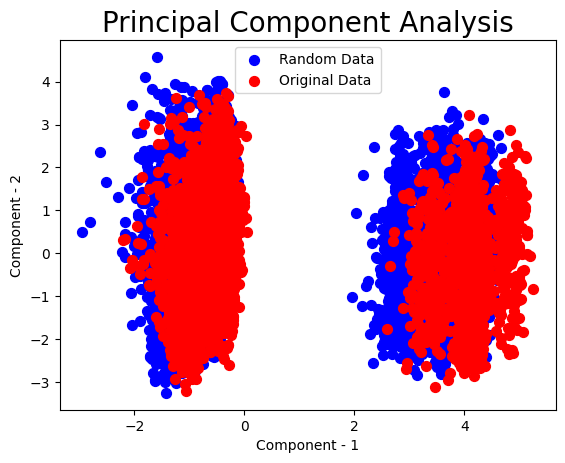

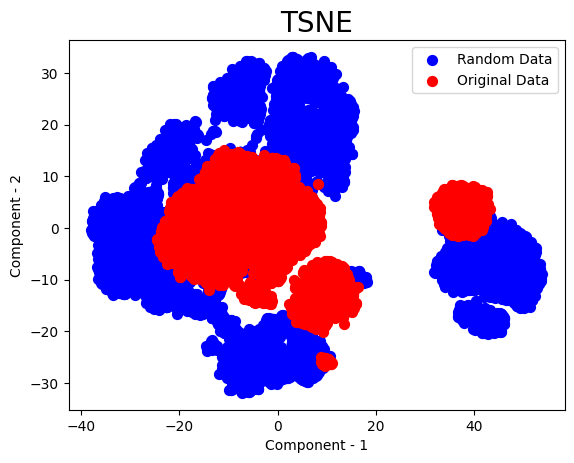

In [5]:
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("./subjects/")
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans
import tensorflow as tf
import time
import random, math
import tensorflow_probability as tfb
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import  euclidean_distances
from Utils_Functions import KLdivergence
from sklearn.feature_selection import SelectKBest, SelectFpr,SelectPercentile 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from aif360.sklearn.metrics import equal_opportunity_difference,average_odds_difference
from Utils_Functions import generate_dataset, eod
import glob
import re
from sklearn.decomposition import PCA
for dataset in ['Adult']:
    if dataset == 'Adult':
        sens_index = 7
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'adult_org-Copy1.csv'
        alg_list = ['pc','ges','simy']
        
    if dataset == 'Compas':
        sens_index = 1
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'compas-Copy1'
        alg_list = ['ges','pc']
        
    if dataset == 'Bank':
        sens_index = 0
        priv_group = 5
        unpriv_group = 3
        data_file_name = 'bank'
        alg_list = ['ges']
        
    if dataset == 'Heart':
        sens_index = 0
        priv_group = 1
        unpriv_group = 0 
        data_file_name = 'heart_processed_1'
        alg_list = ['ges']
        
    if dataset == 'Law':
        sens_index = 1
        priv_group = 1
        unpriv_group = 0
        data_file_name = 'law.csv'
        alg_list = ['ges','simy']

    if dataset == 'Student':
        sens_index = 0
        priv_group = 1
        unpriv_group = 0 
        alg_list = ['simy','pc']
        data_file_name = 'students-processed_2'
        
    df = pd.read_csv('./subjects/datasets/'+data_file_name)
    df =  df.drop_duplicates().reset_index(drop=True)

    X_0 =  df.loc[df[df.columns[sens_index]]==unpriv_group].drop(columns=df.columns[sens_index]).drop(columns=df.columns[-1])
    X_1 = df.loc[df[df.columns[sens_index]]==priv_group].drop(columns=df.columns[sens_index]).drop(columns=df.columns[-1])
    from sklearn.preprocessing import StandardScaler
    se = StandardScaler()
    X_0 = se.fit_transform(X_0)
    X_1 = se.fit_transform(X_1)
    pca = PCA(n_components=2)
    pca.fit(X_0)
    #pca.fit(X_1)
    pca_X_0 = pca.transform(X_0)
    pca_X_1 = pca.transform(X_1)

    plt.figure()

    plt.xlabel('Component - 1',fontsize=10)
    plt.ylabel('Component - 2',fontsize=10)
    plt.title("Principal Component Analysis",fontsize=20)

    plt.scatter(pca_X_0[:,0]
               , pca_X_0[:,1],  c = 'b', s = 50)
    plt.scatter(pca_X_1[:,0]
               , pca_X_1[:,1],  c = 'r', s = 50)

    plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})

    tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=500)
    tsne_X_0 = tsne.fit_transform(X_0)
    tsne_X_1 = tsne.fit_transform(X_1)
    plt.figure()

    plt.xlabel('Component - 1',fontsize=10)
    plt.ylabel('Component - 2',fontsize=10)
    plt.title("TSNE",fontsize=20)

    plt.scatter(tsne_X_0[:,0]
               , tsne_X_0[:,1],  c = 'b', s = 50)
    plt.scatter(tsne_X_1[:,0]
               , tsne_X_1[:,1],  c = 'r', s = 50)
    plt.legend(['Random Data','Original Data', 'Generated Data' ],prop={'size': 10})